In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms, transforms, utils
from torch.utils import data
from torch.utils.data import  Dataset, DataLoader
import pandas as pd

In [170]:
#CNN모델 구현 
#(컨볼루션 -> 풀링)*4 -> 드롭아웃 -> 풀링 -> 신경망 -> 드롭아웃 -> 신경망
#CNN모델의 커널 크기는 5*5 / 컨볼루션 계층은 2개 

#라이브러리 로드 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

#쿠다 사용환경 설정
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

#하이퍼파라미터 설정
EPOCHS = 35
BATCH_SIZE = 4

#전자정보연구정보센터의 이미지 데이터셋 로드
#데이터의 양이 너무 적어 기존데이터의 증식 후, Augmentation을 이용하고자 
#입력각도로 랜덤하게 회전시키는 RandomRotation, 센터의 아핀을 변환시키는 RandomAffine 이용
#그 후, 텐서화와 정규화를 위해 데이터의 평균과 표준편차를 입력 

transformer = transforms.Compose([transforms.Resize((92, 92)),
#                                    transforms.RandomHorizontalFlip(),
                                   transforms.RandomRotation(10),
                                   transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.9758,),(0.0678,))
                                 ])


trainset = torchvision.datasets.ImageFolder(root = './set 02/char_data/train', 
                                           transform = transformer)
testset = torchvision.datasets.ImageFolder(root = './set 02/char_data/test',
                                          transform = transformer)

In [159]:
train_loader = DataLoader (trainset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(testset, batch_size = BATCH_SIZE, shuffle = True)

In [160]:
print(len(train_loader))

984


In [161]:
trainset.__getitem__(1)

(tensor([[[-14.3923, -14.3923, -14.3923,  ..., -14.3923, -14.3923, -14.3923],
          [-14.3923, -14.3923, -14.3923,  ..., -14.3923, -14.3923, -14.3923],
          [-14.3923, -14.3923, -14.3923,  ..., -14.3923, -14.3923, -14.3923],
          ...,
          [-14.3923, -14.3923, -14.3923,  ..., -14.3923, -14.3923, -14.3923],
          [-14.3923, -14.3923, -14.3923,  ..., -14.3923, -14.3923, -14.3923],
          [-14.3923, -14.3923, -14.3923,  ..., -14.3923, -14.3923, -14.3923]],
 
         [[-14.3923, -14.3923, -14.3923,  ..., -14.3923, -14.3923, -14.3923],
          [-14.3923, -14.3923, -14.3923,  ..., -14.3923, -14.3923, -14.3923],
          [-14.3923, -14.3923, -14.3923,  ..., -14.3923, -14.3923, -14.3923],
          ...,
          [-14.3923, -14.3923, -14.3923,  ..., -14.3923, -14.3923, -14.3923],
          [-14.3923, -14.3923, -14.3923,  ..., -14.3923, -14.3923, -14.3923],
          [-14.3923, -14.3923, -14.3923,  ..., -14.3923, -14.3923, -14.3923]],
 
         [[-14.3923, -14.392

In [213]:
#nn.Conv2d모듈은 입력 x를 받는 함수를 반환한다 ( 자신을 바로 부를 수 있지만 함수로 생각해도 무방)
#모델의 학습 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #입력채널수 = 1, 출력 채널수 =10 ( 데이터셋이 흑백이미지로 색상 채널이 1개뿐)
        #kernel_size로 커널 크기 지정 숫자 하나만 지정하면 정사각형으로 간주
        self.conv1 = nn.Conv2d(3,20, 5, 1) # 20@88*88 // pool 20@44*44
        self.conv2 = nn.Conv2d(20,40, 5, 1) # 40@40*40  // pool 400@20*20
        self.conv3 = nn.Conv2d(40, 60, 5, 1) # 60@16*16 // pool 60@8*8
        self.conv4 = nn.Conv2d(60, 80, 5, 1) # 80@4*4 // pool 80@2*2
        #컨볼루션 결과로 나온 출력값에 드롭아웃 
        self.drop = nn.Dropout2d()
        #일반신경망
        #위 계층의 출력값인 80*2*2를 입력 받고 
        #최종 출력을 분류할 클래스 개수인 14개로 설정
        self.fc1 = nn.Linear(80*2*2,80)
        self.fc4 = nn.Linear(80,14)
        
    #출력까지 진행
    def forward(self, x):
        #두개의 각 컨볼루션 계층을 거친 후, max_pool2d 함수 거치기 / 두번째 입력은 커널 크기
        #컨볼루션과 맥스 풀링을 통과한 x는 F.relu함수를 거친다. 
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        #2차원의 특징맵을 바로 입력으로 넣을 수 없어 1차원으로 변환(축소)
        #view()의 첫 입력 -1은 '남는 모든 차원', 80*2*2은 x가 가진 원소갯수
        x = x.view(-1, 80*2*2)
        #앞서 추출한 특징들을 입력으로 받아 분류하는 신경망 계층 구성( 1- ReLu활성화함수 2- 드롭아웃, 3- 0~13레이블)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

In [165]:
#`to()` 함수는 모델의 파라미터들을 지정한 곳으로 보내는 역할을 한다. 일반적으로 CPU 1개만 사용할 경우 필요는 없지만, GPU를 사용하고자 하는 경우 `to("cuda")`로 지정하여 GPU로 보내야 한다.
# 최적화 알고리즘으로는 토치에 내장되어 있는 `optim.SGD`(확률적 경사하강법)와 'optim.Adma' 중 성능이 더 좋은 Adam을 최종선택 

model     = CNN().to(DEVICE)
# optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [166]:
#모델 train모드, F.corss_entropy오차 함수를 이용하여 모델 출력과 정답인 타겟값 사이 오차 계산
#역전파 알고리즘을 실행해주는 loss.backward()함수를 이용해 기울기 계산 후, optimizer.step() 최적화 함수로 구한 기울기값으로 학습 파라미터 갱신

def train(model, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
         #epoch마다 새로운 경사값을 계산하므로 zero_grad()함수를 호출해 경사를 0으로 설정
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output ,target)
        loss.backward()
        optimizer.step()
        
#         if epoch % 10 == 0:
#             print('Train Epoch : {} [{}/{} ({}%)]\t Loss :{}'.format
#                  (epoch ,batch_idx*len(data), len(train_loader.dataset), 100.*batch_idx/len(train_loader), loss.item()))
            

In [167]:
#성능 확인

def evaluate(model, test_loader):
    model.eval()
    #초기값 설정
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            
            #배치 오차 합산
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            
            #가장 높은 값을 가진 인덱스가 예측값
            pred = output.max(1, keepdim = True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100* correct / len(test_loader.dataset)
    return test_loss, test_accuracy    

In [171]:
#학습
for epoch in range(1, EPOCHS +1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    if epoch % 5 ==0:
        print('[{}] Test LOSS : {}, Accuracy : {}'.format(epoch, test_loss, test_accuracy))

[5] Test LOSS : 0.8565666174498509, Accuracy : 83.87755102040816
[10] Test LOSS : 1.2590056559238463, Accuracy : 79.79591836734694
[15] Test LOSS : 1.0172635723316525, Accuracy : 81.83673469387755
[20] Test LOSS : 1.2544254170468443, Accuracy : 83.06122448979592
[25] Test LOSS : 1.0418279666399406, Accuracy : 84.79591836734694
[30] Test LOSS : 1.4658559442566794, Accuracy : 85.20408163265306
[35] Test LOSS : 1.2491411545455815, Accuracy : 86.3265306122449


In [205]:
#실제 성능 테스트
#학습 정확도가 86퍼센트로 처음 33퍼센트에 비해 53퍼나 향상되었음.
#테스트 셋의 이미지를 통해 실제로 예측을 어느정도하는지 확인 

#토치 데이터셋에서 unnormalize, numpy배열로 변환을 하여 이미지 출력을 할 수 있게
#imshow 함수와 tesor(0~13)으로 되어있는 정답 레이블을 표현할 수 있게 classes 정의 
def imshow(img):
    img = img + 0.9758     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
classes = ('AC00: 가', 'B2E4 : 다', 'B9C8 : 마', 'B77C : 라', 'B098 : 나', 'BC14 : 바','C0AC : 사', 'C544 : 아', 'C790 : 자',  
          'CC28 : 차', 'CE74 : 카', 'D0C0 : 타',  'D30C : 파', 'D558 : 하' )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


C0AC : 사 / B77C : 라 / AC00: 가 / D30C : 파


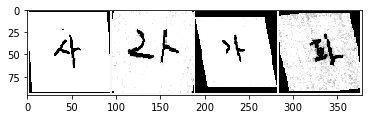

In [208]:
#테스트 데이터에서 무작위 1배치 추출하여
#정답과 이미지 출력
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' / '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()

In [212]:
#에측결과
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' / '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:  C0AC : 사 / B77C : 라 / AC00: 가 / D30C : 파
